In [10]:
import numpy as np

import pickle

from tqdm import tqdm

from pyDOE import lhs

from hydro_code_api import HydroCodeAPI
from hydro_emulation import HydroEmulator

from typing import Any
from typing import Dict
from typing import List
from typing import Tuple
from typing import Type
from typing import Iterable

from pathlib import Path

from multiprocessing import Manager
from multiprocessing import Process

from subprocess import run as cmd
from subprocess import CalledProcessError

from pytensor.tensor import TensorVariable
import pytensor.tensor as at

import pymc as pm

import arviz as az
from pymc.gp.util import plot_gp_dist

import matplotlib.pyplot as plt
import my_plotting as mp

In [3]:
local_params = {
    'tau_0': 0.1,
    'e0': 12.4991,
    'pt0': 4.415,
    'pl0': 3.377,
    'tau_f': 12.1,
    'mass': 0.2 / 0.197,
    'C': 6 / (4 * np.pi),
    'hydro_type': 0
}

In [4]:
def generate_emulator_training_points(
    hydro_params_dict: Dict[str, float | int],
    hydro_parameter_names: List[str],
    hydro_parameter_ranges: np.ndarray,
    observation_times: np.ndarray,
) -> np.ndarray:
    hydro_names = ['ce', 'dnmr', 'mis', 'mvah']

    # instantiate HydroCodeAPI class
    output_dir = 'output_dir/emulator_design_points'
    code_api = HydroCodeAPI(str(Path(output_dir).absolute()))

    # latin hyper cube sample parameter space
    unit = lhs(
        n=len(hydro_inference_parameters),
        samples=10 * len(hydro_inference_parameters),
        criterion='maximin',
    )
    design_points = hydro_inference_parameters_ranges[:, 0] + \
        unit * np.diff(hydro_inference_parameters_ranges, axis=1)

    # run hydro simulations
    # this can be parallelized
    code_api.run_hydro(
        params_dict=hydro_params_dict,
        parameter_names=hydro_inference_parameters,
        design_points=design_points,
        simulation_taus=observation_times,
        hydro_names=hydro_names,
        use_PT_PL=False,
    )

    # extract the observables from the respective files
    # here is worth reminding myself that the HydroCodeAPI does the coalescing
    # of observables at observation times automatically
    hydro_simulations = dict((key, []) for key in hydro_names)
    for k, name in enumerate(hydro_names):
        for j, tau in enumerate(observation_times):
            with open(('{}/{}_simulation_points'
                       + '_n={}_tau={}.dat').
                      format(output_dir,
                             name,
                             len(hydro_inference_parameters),
                             tau),
                      'r') as f_hydro_simulation_pts:
                hydro_simulations[name].append(
                    [
                        [
                            float(entry)
                            for entry in line.split()
                        ]
                        for line in f_hydro_simulation_pts.readlines()
                     ]
                )
    hydro_simulations = dict(
        (key, np.array(hydro_simulations[key])[..., 0:4])
        for key in hydro_simulations
    )

    # return dictionary of observables
    return design_points, hydro_simulations


def generate_psuedo_data(
    error_level: float,
    true_params: Dict[str, Any],
    parameter_names: List[str],
    simulation_taus: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Runs RTA Boltzman solution and then smears it with a Gaussian with a std
    deviation proportional the central value (constant of proportionality given
    by the `error_level`)
    '''
    num_taus = simulation_taus.shape[0]
    code_api = HydroCodeAPI(str(Path('./swap').absolute()))

    # Generate experimental data
    true_params['hydro_type'] = 5
    output = code_api.process_hydro(params_dict=true_params,
                                    parameter_names=parameter_names,
                                    design_point=[true_params[key] for key in
                                                  parameter_names],
                                    use_PT_PL=True)
    tau_start = true_params['tau_0']
    delta_tau = tau_start / 20.0
    observ_indices = (simulation_taus
                      - np.full_like(simulation_taus, tau_start)) / delta_tau

    e = np.array([output[int(i)-1, 1] for i in observ_indices])
    pt = np.array([output[int(i)-1, 2] for i in observ_indices])
    pl = np.array([output[int(i)-1, 3] for i in observ_indices])

    pt_err = error_level * pt
    pl_err = error_level * pl
    exact_pseudo = np.zeros((simulation_taus.shape[0], 4))

    for i, tau in enumerate(simulation_taus):
        exact_pseudo[i, 0] = tau

    ex = np.fabs(np.random.normal(e, np.fabs(e * error_level)))
    ptx = np.random.normal(pt, np.fabs(pt_err))
    plx = np.random.normal(pl, np.fabs(pl_err))

    return np.array(
        [
            (simulation_taus[i], ex[i], ptx[i], plx[i])
            for i in range(num_taus)
        ]
    ), error_level * np.array(
            [
                (e[i], pt[i], pl[i])
                for i in range(num_taus)
            ]
        )

In [5]:
def sequential_calibration(
    hydo_emulators: HydroEmulator,
    local_parameters: Dict[str, Any],
    data: np.ndarray,
    error_bar: np.ndarray
):
    '''
    Run calibration of individual models, then do model mixing
    '''
    # Use PyMC for individual calibrations and model mixing
    return NotImplemented

In [6]:
def simultaneous_calibration(
    hydro_names: List[str],
    hydro_inference_parameters: List[str],
    hydro_inference_parameters_ranges: np.ndarray,
    observation_times: np.ndarray,
    observation_data: np.ndarray,
    observation_error: np.ndarray,
    emulator_training_data: Dict[str, np.ndarray],
    emulator_design_points: np.ndarray
):
    '''
    Run calibration of model and model mixing simultaneously
    '''

    with pm.Model() as gp_emulators:
        # setup for gp emulator
        cov_func = pm.gp.cov.Matern32(
            input_dim=len(hydro_inference_parameters),
            ls=np.diff(hydro_inference_parameters_ranges, axis=1)
        )

        emulators = dict((key, []) for key in hydro_names)
        for name in hydro_names:
            for i, training_data in enumerate(emulator_training_data[name]):
                observable_emulators = []
                for j, observable in enumerate(['e', 'pi', 'Pi']):
                    observable_emulators.append(
                        pm.gp.Marginal(cov_func=cov_func)
                    )
                    observable_emulators[-1].marginal_likelihood(
                        name=f'{name}_{observable}_{i}_trainining',
                        X=emulator_design_points,
                        y=training_data[:, j + 1],
                        sigma=0,
                    )
                emulators[name].append(observable_emulators)

    # I have verified for myself that the emulators look good, but it would
    # be nice to have a bit of code here that does the checking and plotting

    # Use PyMC for simulatneous calibrations (probably simpler)
    # return NotImplemented


    with pm.Model() as inference_model:
        inference_vars = pm.Uniform(
            'hydro_inference_vars',
            lower=hydro_inference_parameters_ranges[:, 0],
            upper=hydro_inference_parameters_ranges[:, 1],
            shape=(len(hydro_inference_parameters), 1)
        )

        hydro_emulators = [
            [
                [
                    emulators[name][i][j].conditional(
                               name=f'{name}_{observable}_{i}_conditional',
                               Xnew=inference_vars,
                            )
                    for j, observable in enumerate(['e', 'pi', 'Pi'])
                ]
                for i, tau in enumerate(observation_times)
            ]
            for name in hydro_names
        ]

        for i, tau in enumerate(observation_times):
            comp_dists = [
                pm.MvNormal.dist(
                    # f'normal_{name}_{tau}',
                    mu=hydro_emulators[n][i],
                    cov=np.diag(observation_error[i]),
                )
                for n, name in enumerate(hydro_names)
            ]
    
            alpha = pm.Lognormal(
                f'alpha',
                mu=0.0,
                sigma=1.0,
                shape=len(hydro_names)
            )
            weights = pm.Dirichlet(f'Dirichlet', a=alpha)
            
            pm.Mixture(
                f'mix_{i}',
                w=weights,
                comp_dists=comp_dists,
                observed=observation_data[i, 1:].reshape(-1, 1)
            )
    
    print('Done building PyTensor Graph')
    with inference_model:
        idata = pm.sample(
            draws=1_000,
            tune=1_000,
            target_accept=0.95
        )
        
    # az.plot_trace(idata, combined=True)
    rta_const = np.linspace(2, 8, 20) / (4 * np.pi)
    
    with inference_model:
        emulator_predictions = pm.sample_posterior_predictive(
            idata.sel(draws=slice(0, 20)),
            var_names=[
                f'{name}_{observable}_{i}_conditional'
                for observable in ['e', 'pi', 'Pi']
                for i, _ in enumerate(observation_times)
                for name in hydro_names
            ],
        )
    
    return idata, emulator_predictions

# Small Attempts to see if PyTensor gets compiled

## One observation time

In [8]:
%%time 
true_params = local_params

hydro_names = ['ce', 'dnmr', 'mis', 'mvah']
hydro_inference_parameters = ['C']
hydro_inference_parameters_ranges = np.array([[1, 10]]) / (4 * np.pi)
# simulation_taus = np.linspace(5.1, 12.1, 8)
simulation_taus = np.array([5.1])

# Generate psuedo_data
data, error_bar = generate_psuedo_data(
    error_level=0.05,
    parameter_names=hydro_inference_parameters,
    true_params=true_params,
    simulation_taus=simulation_taus,
)

print(data)

# Generate training points to train emulator
design_points, emulator_training_data = generate_emulator_training_points(
    hydro_params_dict=local_params,
    hydro_parameter_names=hydro_inference_parameters,
    hydro_parameter_ranges=hydro_inference_parameters_ranges,
    observation_times=simulation_taus,
)

Initialize temperatures	
Calculating temperature evoluton.	
n = 0, err = 0.7849676469378367	
n = 1, err = 0.06904204591429339	
n = 2, err = 0.05911214773042373	
n = 3, err = 0.044656453786889344	
n = 4, err = 0.031102391898874898	
n = 5, err = 0.02017568697389817	
n = 6, err = 0.012141378812955347	
n = 7, err = 0.006739871199544651	
n = 8, err = 0.0034326798915585532	
n = 9, err = 0.0015914497753295128	
n = 10, err = 0.0006858163667070855	
n = 11, err = 0.0002646386876602925	
n = 12, err = 9.497336963484697e-05	
n = 13, err = 3.391583948231828e-05	
n = 14, err = 6.782937847496284e-06	
n = 15, err = 6.782891839444827e-06	
n = 16, err = 0	
Temperature evolution calculation terminated successfully.	
Calculating moments of distribution function.	
[[5.1        0.1546577  0.05991818 0.0247807 ]]


dnmr:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

mis:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


ce:  10%|███████▊                                                                      | 1/10 [00:01<00:11,  1.24s/it]


ce:  20%|███████████████▌                                                              | 2/10 [00:02<00:09,  1.18s/it]

dnmr:  10%|███████▌                                                                    | 1/10 [00:02<00:25,  2.87s/it]


ce:  40%|███████████████████████████████▏                                              | 4/10 [00:04<00:06,  1.16s/it]


mvah:  30%|██████████████████████▊                                                     | 3/10 [00:05<00:11,  1.67s/it]

ce:  50%|███████████████████████████████████████                                       | 5/10 [00:06<00:06,  1.21s/it]


ce:  60%|██████████████████████████

CPU times: user 121 ms, sys: 60.4 ms, total: 181 ms
Wall time: 16min 7s


In [68]:
# sequential calibration

In [33]:
%%time

# simultaneous calibration
inference_data, emulator_predictions = simultaneous_calibration(
    hydro_names=hydro_names,
    hydro_inference_parameters=hydro_inference_parameters,
    hydro_inference_parameters_ranges=hydro_inference_parameters_ranges,
    observation_times=simulation_taus,
    observation_data=data,
    observation_error=error_bar,
    emulator_training_data=emulator_training_data,
    emulator_design_points=design_points,
)

Done building PyTensor Graph


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hydro_inference_vars, ce_e_0_conditional, ce_pi_0_conditional, ce_Pi_0_conditional, dnmr_e_0_conditional, dnmr_pi_0_conditional, dnmr_Pi_0_conditional, mis_e_0_conditional, mis_pi_0_conditional, mis_Pi_0_conditional, mvah_e_0_conditional, mvah_pi_0_conditional, mvah_Pi_0_conditional, alpha, Dirichlet]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2600 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [ce_Pi_0_conditional, ce_e_0_conditional, ce_pi_0_conditional, dnmr_Pi_0_conditional, dnmr_e_0_conditional, dnmr_pi_0_conditional, mis_Pi_0_conditional, mis_e_0_conditional, mis_pi_0_conditional, mvah_Pi_0_conditional, mvah_e_0_conditional, mvah_pi_0_conditional]


CPU times: user 2min 21s, sys: 4.92 s, total: 2min 26s
Wall time: 45min 17s


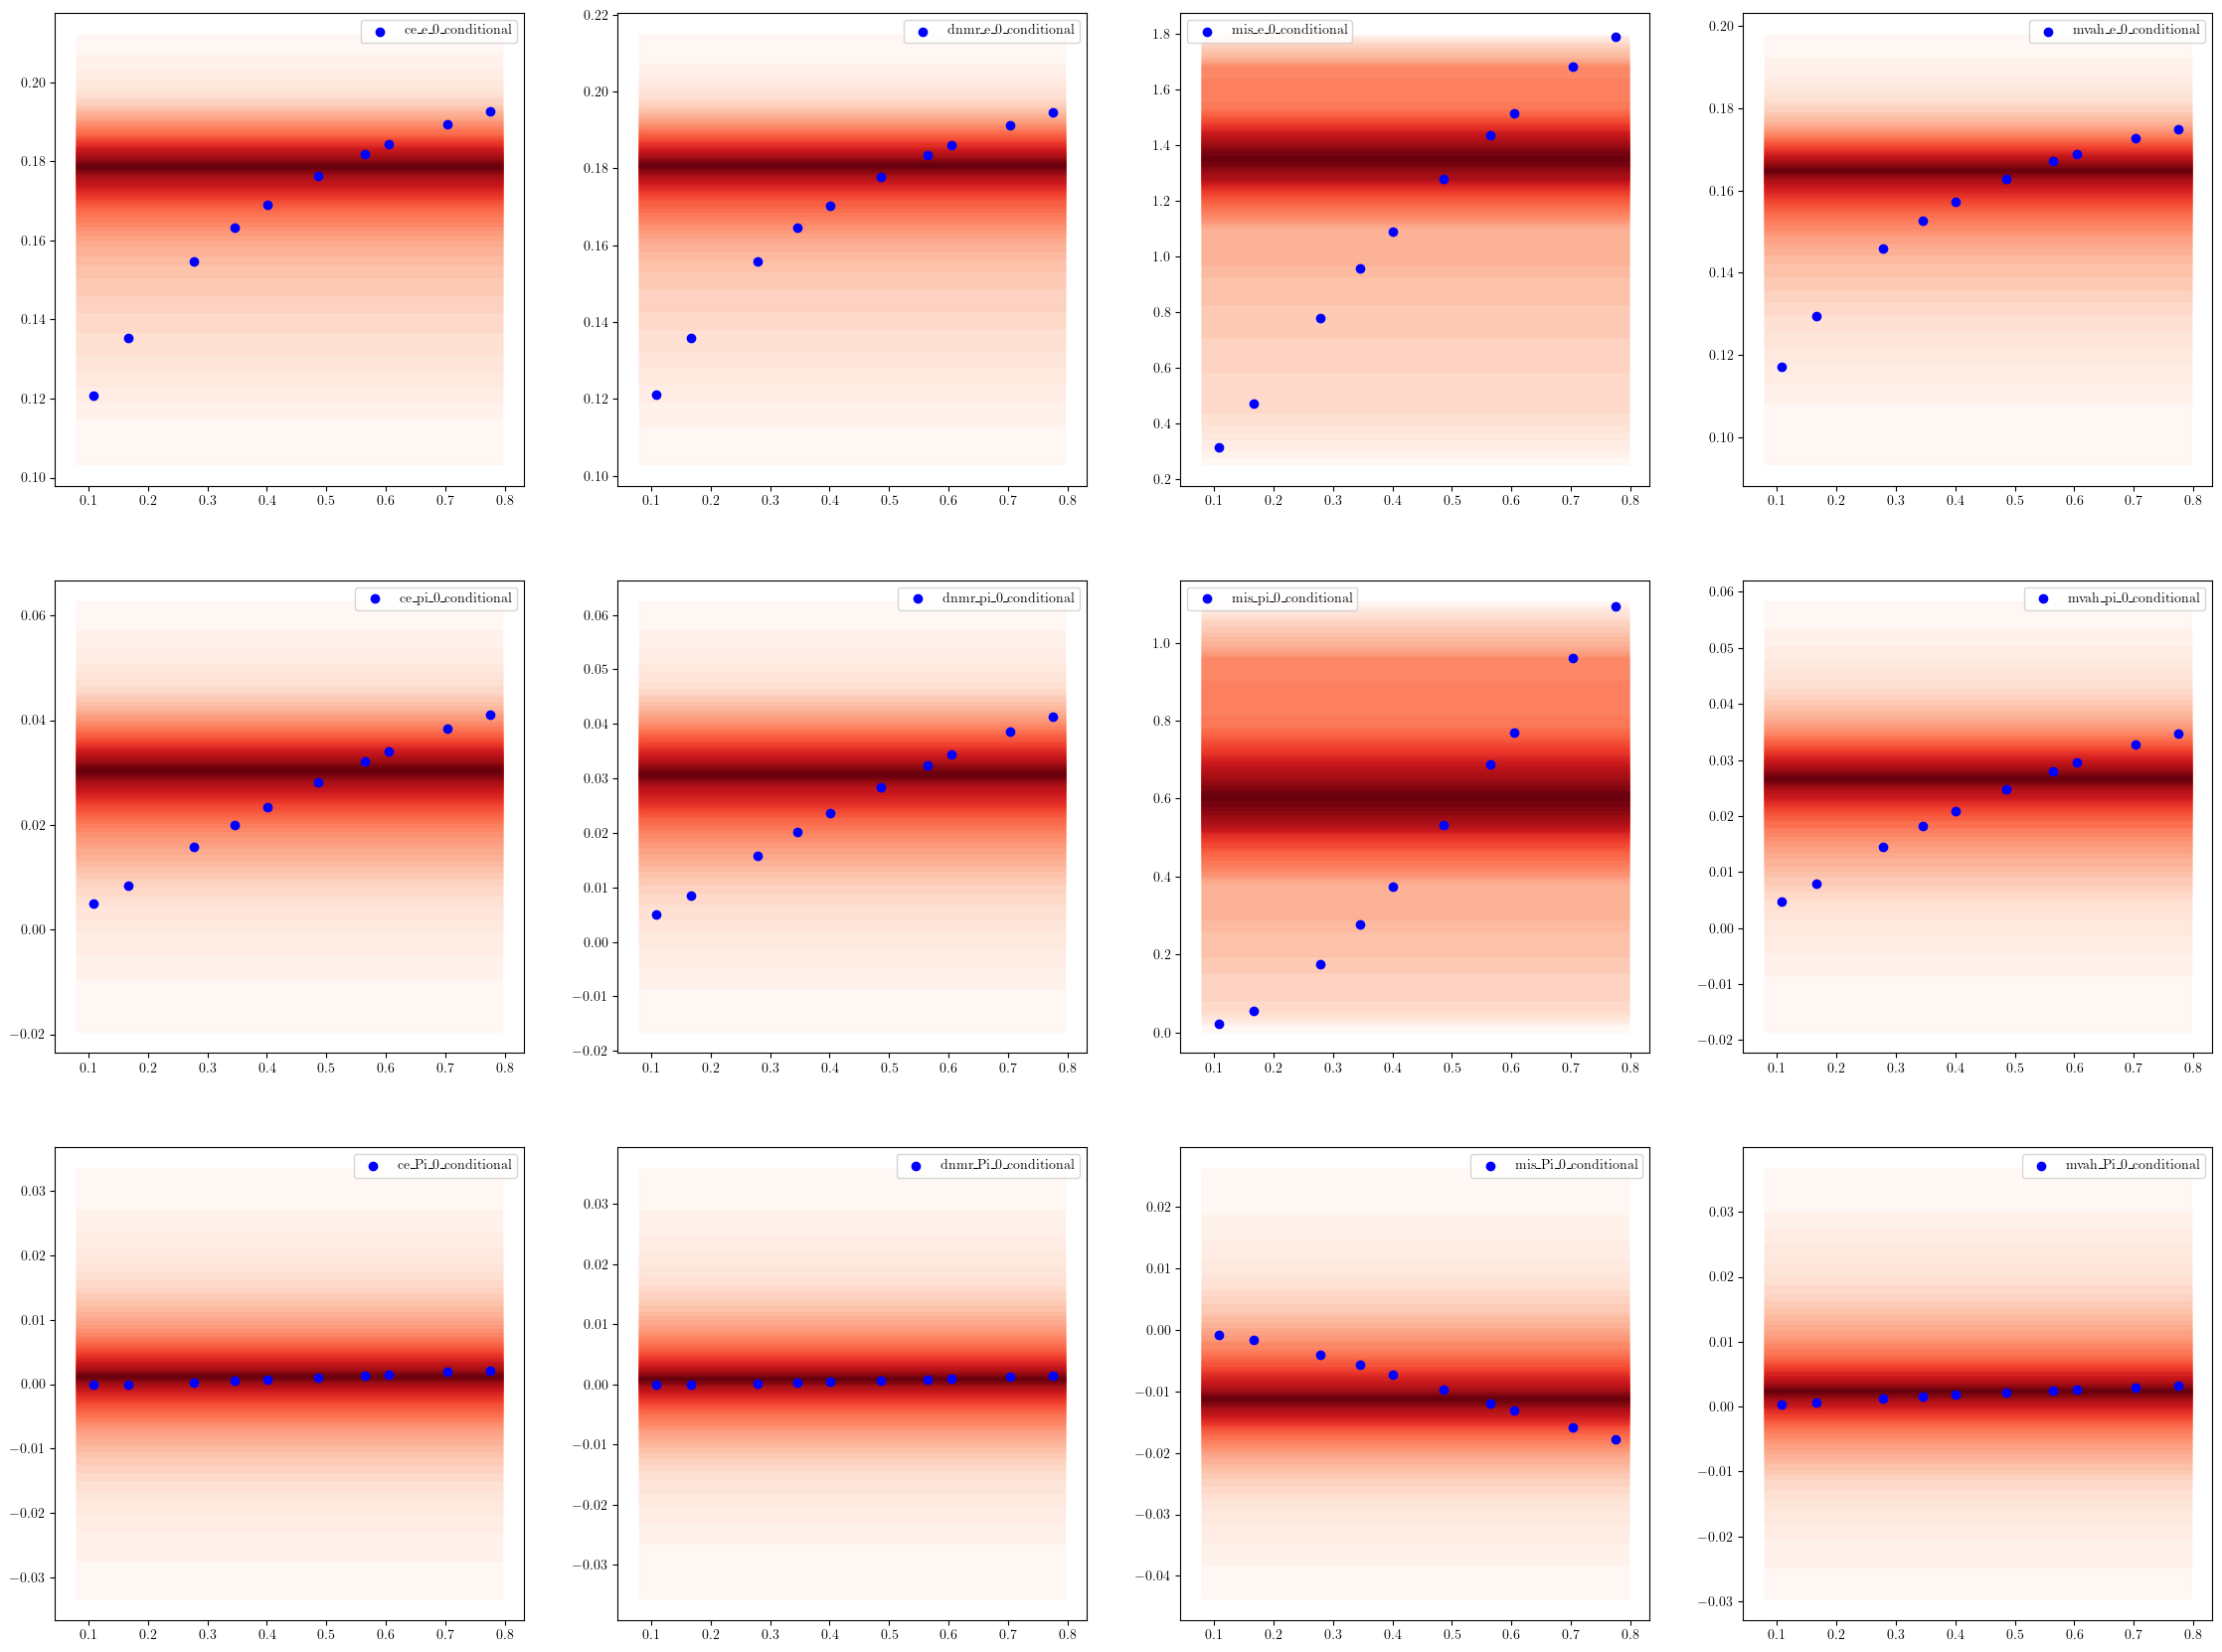

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(28,21))
for j, observable in enumerate(['e', 'pi', 'Pi']):
    for i, name in enumerate(hydro_names):
        pred_samples = az.extract(
            emulator_predictions,
            group="posterior_predictive",
            var_names=f'{name}_{observable}_0_conditional',
        )
        plot_gp_dist(ax[j, i], pred_samples.T, rta_const.reshape(-1, 1), plot_samples=False)
        ax[j, i].scatter(
            design_points,
            emulator_training_data[name][0, :, j + 1],
            color='blue',
            label=f'{name}_{observable}_0_conditional'
        )
        ax[j, i].legend()

(4, 1000, 4)


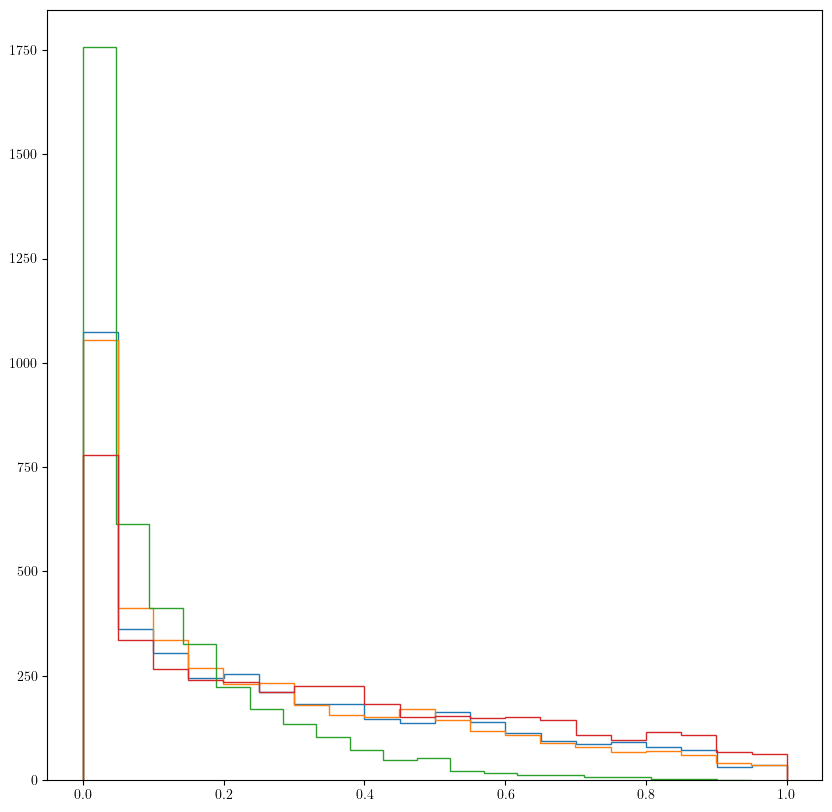

In [15]:
print(inference_data.posterior['Dirichlet'].shape)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(inference_data.posterior['Dirichlet'].shape[0]):
    ax.hist(np.array(inference_data.posterior['Dirichlet'][..., i]).flatten(), histtype='step', bins=20)

(4, 1000, 1, 1)


(array([247., 293., 643., 785.,  32.,   0.,   4., 184., 910., 902.]),
 array([0.32212553, 0.36410092, 0.40607632, 0.44805172, 0.49002712,
        0.53200251, 0.57397791, 0.61595331, 0.65792871, 0.6999041 ,
        0.7418795 ]),
 <BarContainer object of 10 artists>)

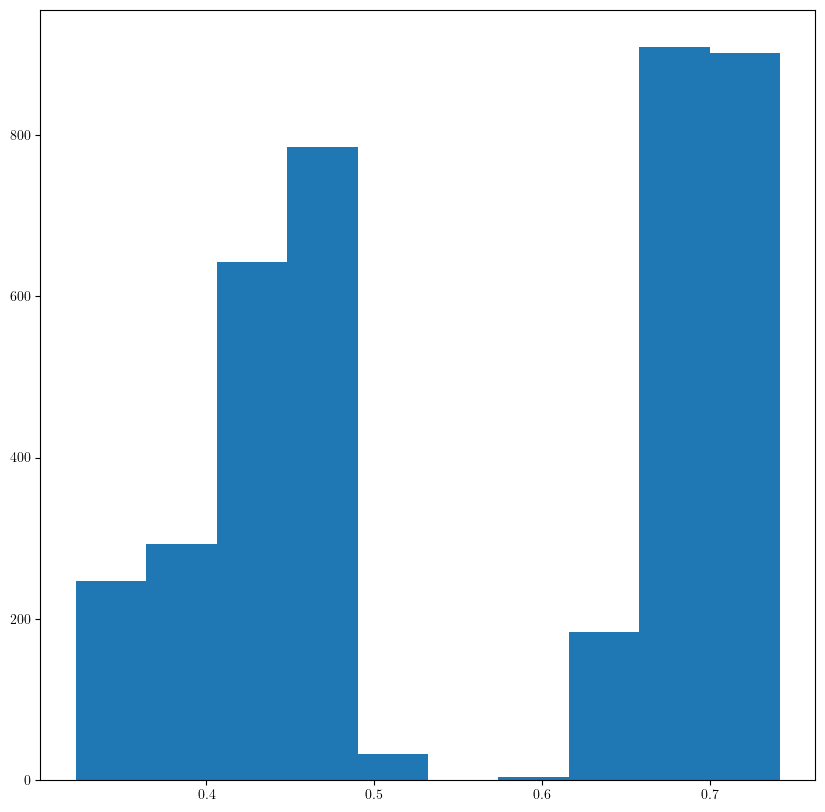

In [17]:
print(inference_data.posterior['hydro_inference_vars'].shape)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(4):
    ax.hist(np.array(inference_data.posterior['hydro_inference_vars']).flatten())

In [9]:
rta_const = np.linspace(1, 10) / (4 * np.pi)

with pm.Model() as model:
    cov_func  = pm.gp.cov.Matern32(
        input_dim=1,
        ls=9 / (4 * np.pi)
    )
    emulators = dict((key, []) for key in hydro_names)
    for name in hydro_names:
        for i, training_data in enumerate(emulator_training_data[name]):
            observable_emulators = []
            for j, observable in enumerate(['e', 'pi', 'Pi']):
                observable_emulators.append(
                    pm.gp.Marginal(cov_func=cov_func)
                )
                observable_emulators[-1].marginal_likelihood(
                    name=f'{name}_{observable}_{i}_trainining',
                    X=design_points,
                    y=training_data[:, j + 1],
                    sigma=0,
                )
            emulators[name].append(observable_emulators)
    
    pred = [
        [
            [
                emulators[name][i][j].conditional(
                    f'{name}_{observable}_{i}_conditional',
                    rta_const.reshape(-1, 1)
                )
                for j, observable in enumerate(['e', 'pi', 'Pi'])
            ]
            for i in range(len(simulation_taus))
        ]
        for n, name in enumerate(hydro_names)
    ]

    idata = pm.sample(500, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ce_e_0_conditional, ce_pi_0_conditional, ce_Pi_0_conditional, dnmr_e_0_conditional, dnmr_pi_0_conditional, dnmr_Pi_0_conditional, mis_e_0_conditional, mis_pi_0_conditional, mis_Pi_0_conditional, mvah_e_0_conditional, mvah_pi_0_conditional, mvah_Pi_0_conditional]


Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 530 seconds.


['ce_e_0_conditional', 'dnmr_e_0_conditional', 'mis_e_0_conditional', 'mvah_e_0_conditional', 'ce_pi_0_conditional', 'dnmr_pi_0_conditional', 'mis_pi_0_conditional', 'mvah_pi_0_conditional', 'ce_Pi_0_conditional', 'dnmr_Pi_0_conditional', 'mis_Pi_0_conditional', 'mvah_Pi_0_conditional']


Sampling: [ce_e_0_conditional]


Sampling: [dnmr_e_0_conditional]


Sampling: [mis_e_0_conditional]


Sampling: [mvah_e_0_conditional]


Sampling: [ce_pi_0_conditional]


Sampling: [dnmr_pi_0_conditional]


Sampling: [mis_pi_0_conditional]


Sampling: [mvah_pi_0_conditional]


Sampling: [ce_Pi_0_conditional]


Sampling: [dnmr_Pi_0_conditional]


Sampling: [mis_Pi_0_conditional]


Sampling: [mvah_Pi_0_conditional]


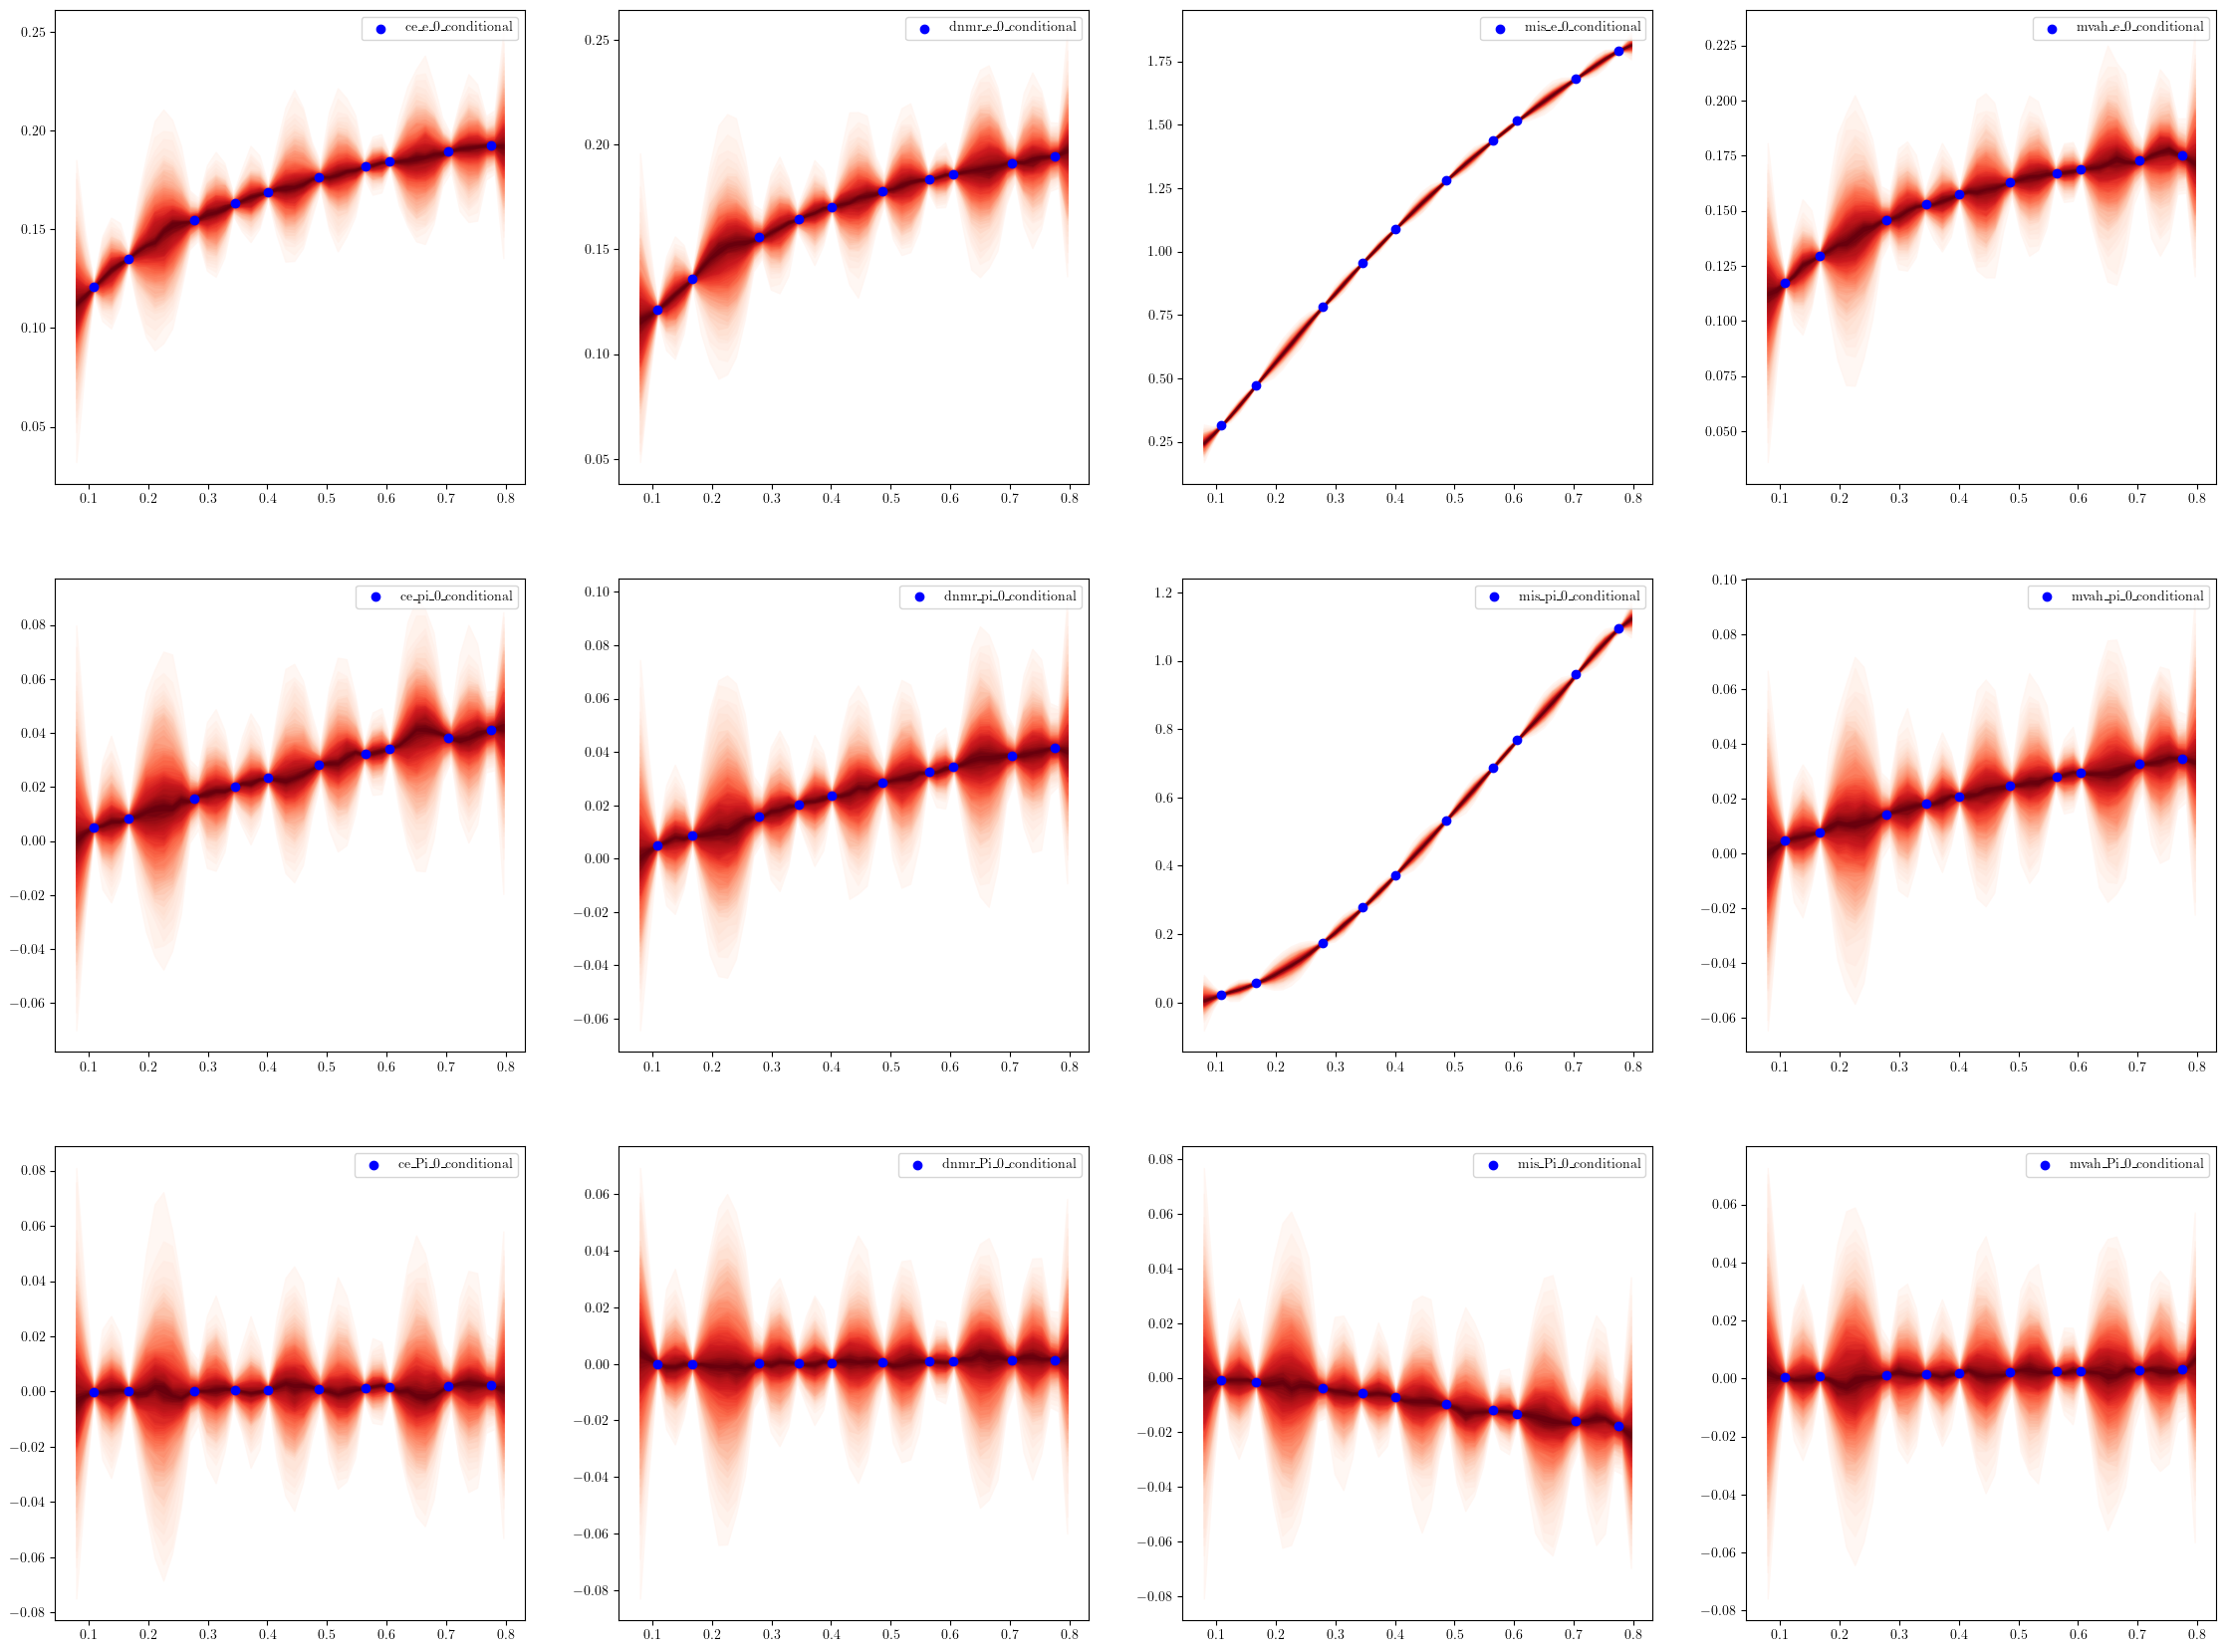

In [30]:
var_names = [
    f'{name}_{observable}_{i}_conditional'
    for observable in ['e', 'pi', 'Pi']
    for i in range(len(simulation_taus))
    for name in hydro_names
]
print(var_names)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(28,21))


for j, observable in enumerate(['e', 'pi', 'Pi']):
    for i, name in enumerate(hydro_names):
        with model:     
            pred_samples = pm.sample_posterior_predictive(
                idata.sel(draw=slice(0, 100)),
                var_names=[f'{name}_{observable}_0_conditional']
            )
        pred_samples = az.extract(
            pred_samples,
            group="posterior_predictive",
            var_names=f'{name}_{observable}_0_conditional',
        )
        plot_gp_dist(ax[j, i], pred_samples.T, rta_const.reshape(-1, 1), plot_samples=False)
        ax[j, i].scatter(
            design_points,
            emulator_training_data[name][0, :, j + 1],
            color='blue',
            label=f'{name}_{observable}_0_conditional'
        )
        ax[j, i].legend()

In [23]:
pred_samples

<xarray.DataArray 'ce_e_0_conditional' (ce_e_0_conditional_dim_2: 50, sample: 84)>
array([[0.13849035, 0.1373759 , 0.14040022, ..., 0.13623001, 0.14145817,
        0.13687903],
       [0.13598903, 0.1320668 , 0.13413505, ..., 0.13635597, 0.13547652,
        0.13693373],
       [0.13211591, 0.13713277, 0.12121231, ..., 0.13776196, 0.12961519,
        0.1310203 ],
       ...,
       [0.18310571, 0.17360646, 0.20006426, ..., 0.20195492, 0.1983295 ,
        0.1813774 ],
       [0.17160933, 0.170184  , 0.20868638, ..., 0.21029317, 0.21000023,
        0.17554669],
       [0.16147703, 0.17392554, 0.20703608, ..., 0.21732007, 0.21671702,
        0.16361983]])
Coordinates:
  * ce_e_0_conditional_dim_2  (ce_e_0_conditional_dim_2) int64 0 1 2 ... 48 49
  * sample                    (sample) object MultiIndex
  * chain                     (sample) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw                      (sample) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20

## Two observation times

In [6]:
%%time 
true_params = local_params

hydro_names = ['ce', 'dnmr', 'mis', 'mvah']
hydro_inference_parameters = ['C']
hydro_inference_parameters_ranges = np.array([[1, 10]]) / (4 * np.pi)
# simulation_taus = np.linspace(5.1, 12.1, 8)
simulation_taus = np.array([5.1, 6.1])

# Generate psuedo_data
data, error_bar = generate_psuedo_data(
    error_level=0.05,
    parameter_names=hydro_inference_parameters,
    true_params=true_params,
    simulation_taus=simulation_taus,
)

print(data)

# Generate training points to train emulator
design_points, emulator_training_data = generate_emulator_training_points(
    hydro_params_dict=local_params,
    hydro_parameter_names=hydro_inference_parameters,
    hydro_parameter_ranges=hydro_inference_parameters_ranges,
    observation_times=simulation_taus,
)

Initialize temperatures	
Calculating temperature evoluton.	
n = 0, err = 0.7849677995484283	
n = 1, err = 0.06905217487788633	
n = 2, err = 0.05910851803343276	
n = 3, err = 0.04464149528233618	
n = 4, err = 0.031107028263468735	
n = 5, err = 0.020177729485527044	
n = 6, err = 0.012141907968597931	
n = 7, err = 0.006743496086375919	
n = 8, err = 0.0034294870095976358	
n = 9, err = 0.0015940292753073952	
n = 10, err = 0.0006810753458731379	
n = 11, err = 0.00027085571551364694	
n = 12, err = 9.720392861137094e-05	
n = 13, err = 2.7769851693065884e-05	
n = 14, err = 1.3884540274942014e-05	
n = 15, err = 0	
Temperature evolution calculation terminated successfully.	
Calculating moments of distribution function.	
[[5.1        0.15302384 0.0629088  0.02390591]
 [6.1        0.12901084 0.04691521 0.01922975]]


dnmr:   0%|                                              | 0/10 [00:00<?, ?it/s]

mis:   0%|                                               | 0/10 [00:00<?, ?it/s]


dnmr:  10%|███▊                                  | 1/10 [00:01<00:17,  1.93s/it]

mis:  10%|███▉                                   | 1/10 [00:02<00:21,  2.40s/it]


ce:  30%|████████████                            | 3/10 [00:04<00:09,  1.36s/it]


mvah:  20%|███████▌                              | 2/10 [00:04<00:17,  2.25s/it]

ce:  50%|████████████████████                    | 5/10 [00:06<00:06,  1.34s/it]


dnmr:  40%|███████████████▏                      | 4/10 [00:07<00:10,  1.79s/it]

ce:  60%|████████████████████████                | 6/10 [00:08<00:05,  1.33s/it]


ce:  70%|████████████████████████████            | 7/10 [00:09<00:03,  1.30s/it]

dnmr:  60%|██████████████████████▊               | 6/10 [00:10<00:07,  1.79s/it]


ce:  90%|████████████████████████████████████    | 9/10 [00:12<00:01,  1.44s/it]

ce: 100%|█

CPU times: user 154 ms, sys: 138 ms, total: 292 ms
Wall time: 46.9 s


(2, 10, 4)
(2, 4)
Done building PyTensor Graph


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hydro_inference_vars, ce_e_0, ce_pi_0, ce_Pi_0, dnmr_e_0, dnmr_pi_0, dnmr_Pi_0, mis_e_0, mis_pi_0, mis_Pi_0, mvah_e_0, mvah_pi_0, mvah_Pi_0, alpha_0, Dirichlet_0, ce_e_1, ce_pi_1, ce_Pi_1, dnmr_e_1, dnmr_pi_1, dnmr_Pi_1, mis_e_1, mis_pi_1, mis_Pi_1, mvah_e_1, mvah_pi_1, mvah_Pi_1, alpha_1, Dirichlet_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2210 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 620 divergences after tuning. Increase `target_accept` or reparameterize.
/home/kevin/research_env/lib/python3.10/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (29), generating only 20 plots
  warnings.warn(


CPU times: user 5min 22s, sys: 4.15 s, total: 5min 26s
Wall time: 41min 58s


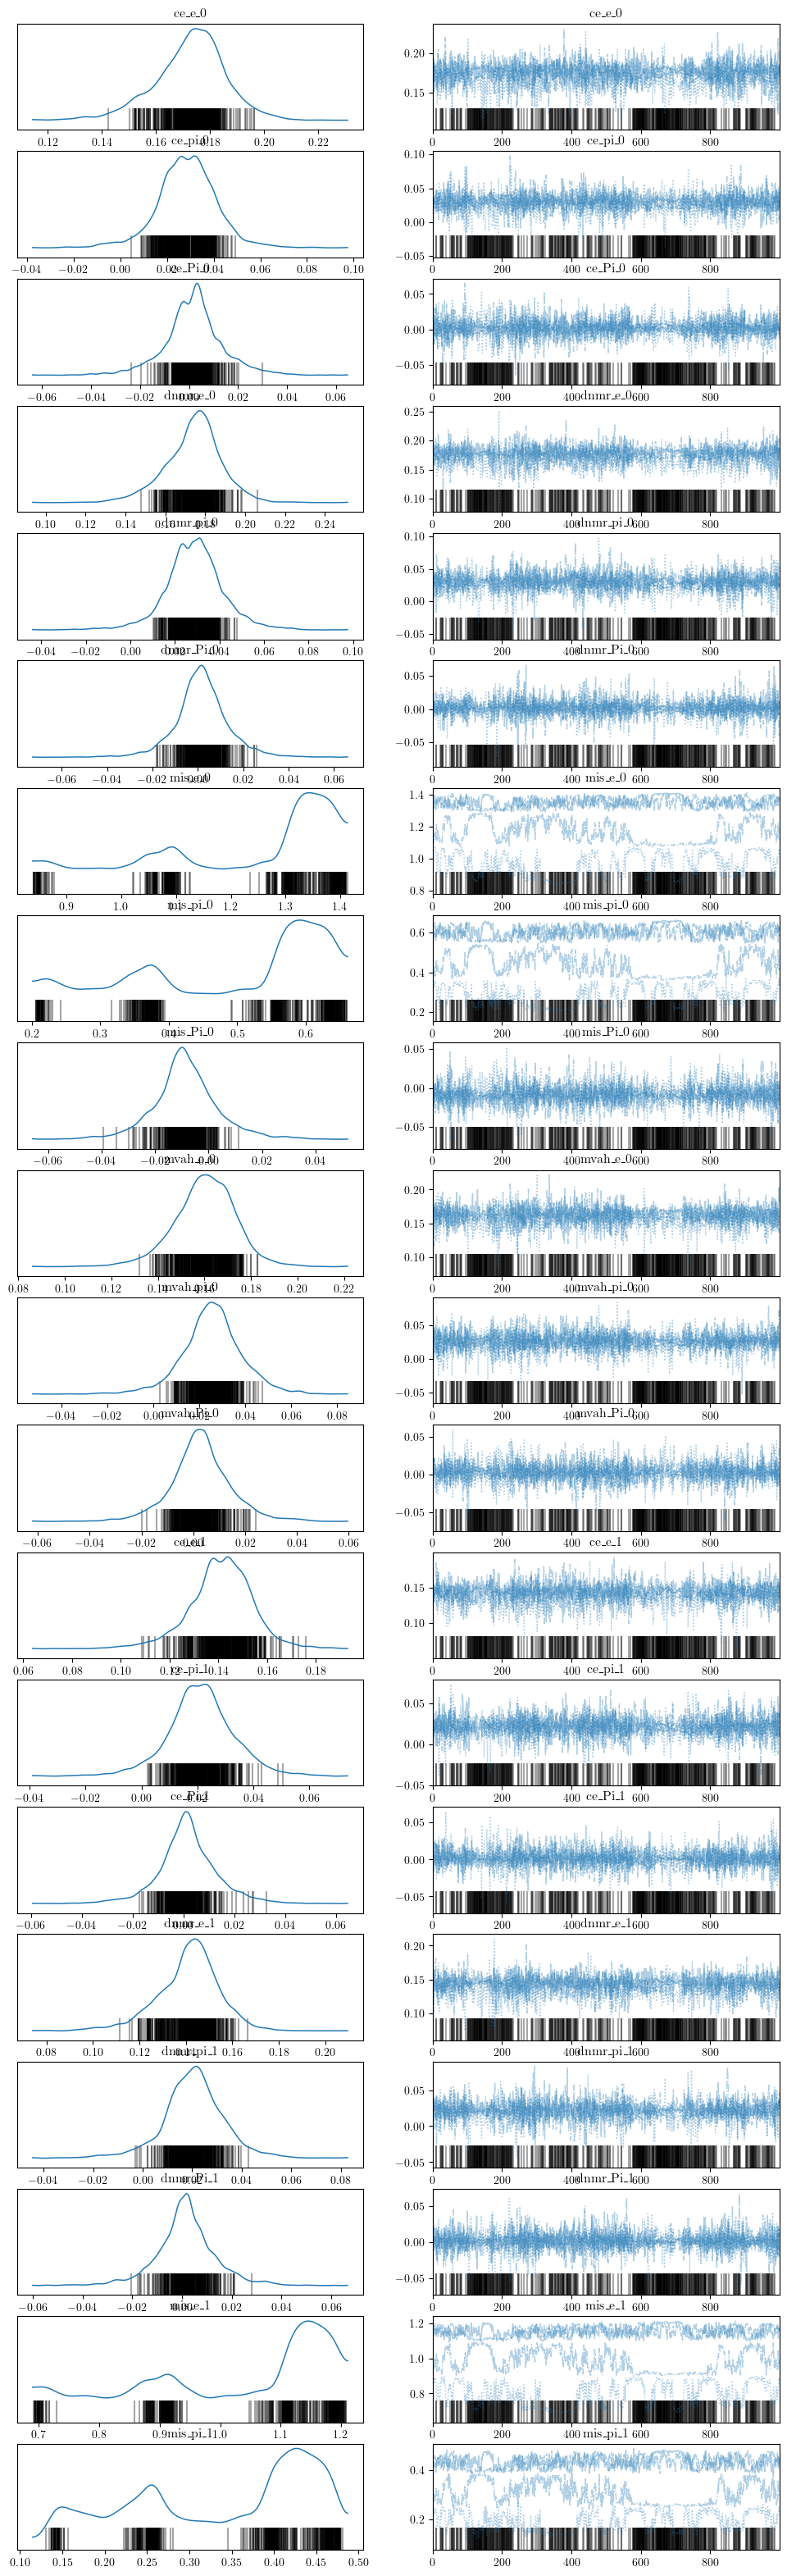

In [7]:
%%time

# simultaneous calibration
inference_data = simultaneous_calibration(
    hydro_names=hydro_names,
    hydro_inference_parameters=hydro_inference_parameters,
    hydro_inference_parameters_ranges=hydro_inference_parameters_ranges,
    observation_times=simulation_taus,
    observation_data=data,
    observation_error=error_bar,
    emulator_training_data=emulator_training_data,
    emulator_design_points=design_points,
)

(4, 1000, 4)


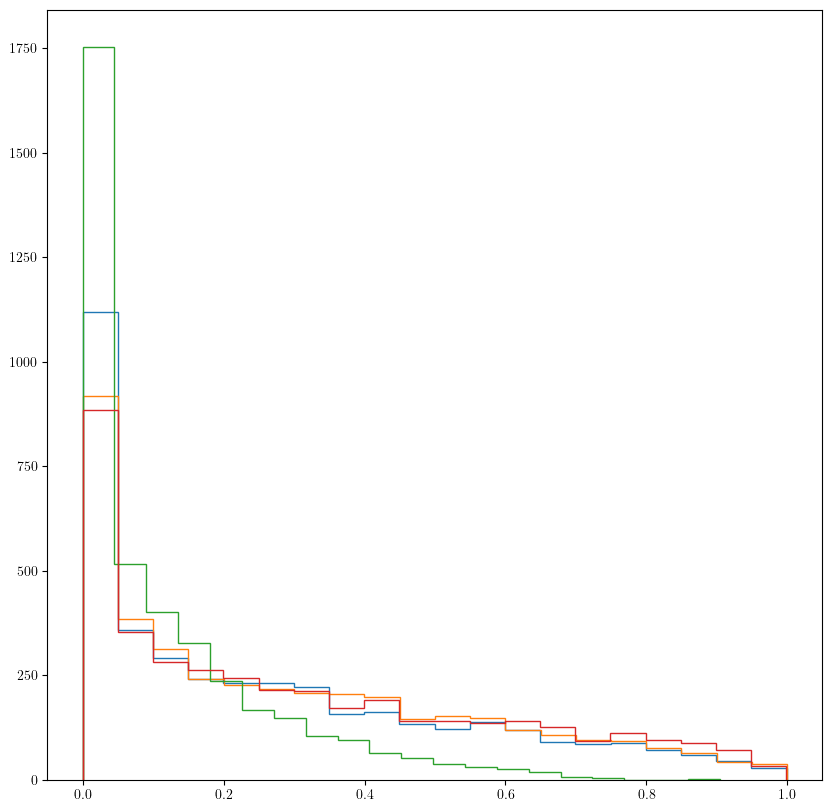

In [8]:
print(inference_data.posterior['Dirichlet_0'].shape)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(inference_data.posterior['Dirichlet_0'].shape[0]):
    ax.hist(np.array(inference_data.posterior['Dirichlet_0'][..., i]).flatten(), histtype='step', bins=20)

## Three Observation Times

In [6]:
%%time 
true_params = local_params

hydro_names = ['ce', 'dnmr', 'mis', 'mvah']
hydro_inference_parameters = ['C']
hydro_inference_parameters_ranges = np.array([[1, 10]]) / (4 * np.pi)
# simulation_taus = np.linspace(5.1, 12.1, 8)
simulation_taus = np.array([5.1, 6.1, 7.1])

# Generate psuedo_data
data, error_bar = generate_psuedo_data(
    error_level=0.05,
    parameter_names=hydro_inference_parameters,
    true_params=true_params,
    simulation_taus=simulation_taus,
)

print(data)

# Generate training points to train emulator
design_points, emulator_training_data = generate_emulator_training_points(
    hydro_params_dict=local_params,
    hydro_parameter_names=hydro_inference_parameters,
    hydro_parameter_ranges=hydro_inference_parameters_ranges,
    observation_times=simulation_taus,
)

Initialize temperatures	
Calculating temperature evoluton.	
n = 0, err = 0.7849677995484283	
n = 1, err = 0.06905217487788633	
n = 2, err = 0.05910851803343276	
n = 3, err = 0.04464149528233618	
n = 4, err = 0.031107028263468735	
n = 5, err = 0.020177729485527044	
n = 6, err = 0.012141907968597931	
n = 7, err = 0.006743496086375919	
n = 8, err = 0.0034294870095976358	
n = 9, err = 0.0015940292753073952	
n = 10, err = 0.0006810753458731379	
n = 11, err = 0.00027085571551364694	
n = 12, err = 9.720392861137094e-05	
n = 13, err = 2.7769851693065884e-05	
n = 14, err = 1.3884540274942014e-05	
n = 15, err = 0	
Temperature evolution calculation terminated successfully.	
Calculating moments of distribution function.	
[[5.1        0.16921589 0.06151703 0.02449018]
 [6.1        0.13145851 0.04645532 0.02135024]
 [7.1        0.11153082 0.03954741 0.01886554]]


dnmr:   0%|                                              | 0/10 [00:00<?, ?it/s]

mis:   0%|                                               | 0/10 [00:00<?, ?it/s]


dnmr:  10%|███▊                                  | 1/10 [00:01<00:17,  1.92s/it]


ce:  20%|████████                                | 2/10 [00:02<00:11,  1.45s/it]

dnmr:  20%|███████▌                              | 2/10 [00:04<00:16,  2.08s/it]


ce:  40%|████████████████                        | 4/10 [00:05<00:08,  1.40s/it]

mis:  20%|███████▊                               | 2/10 [00:05<00:22,  2.81s/it]



ce:  50%|████████████████████                    | 5/10 [00:07<00:07,  1.43s/it]

dnmr:  40%|███████████████▏                      | 4/10 [00:09<00:14,  2.34s/it]


ce:  70%|████████████████████████████            | 7/10 [00:10<00:04,  1.44s/it]

dnmr:  50%|███████████████████                   | 5/10 [00:10<00:10,  2.20s/it]


dnmr:  60%|██████████████████████▊               | 6/10 [00:13<00:09,  2.31s/it]

ce: 100%|

CPU times: user 156 ms, sys: 135 ms, total: 291 ms
Wall time: 47.9 s


(3, 10, 4)
(3, 4)
Done building PyTensor Graph


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hydro_inference_vars, ce_e_0, ce_pi_0, ce_Pi_0, dnmr_e_0, dnmr_pi_0, dnmr_Pi_0, mis_e_0, mis_pi_0, mis_Pi_0, mvah_e_0, mvah_pi_0, mvah_Pi_0, alpha_0, Dirichlet_0, ce_e_1, ce_pi_1, ce_Pi_1, dnmr_e_1, dnmr_pi_1, dnmr_Pi_1, mis_e_1, mis_pi_1, mis_Pi_1, mvah_e_1, mvah_pi_1, mvah_Pi_1, alpha_1, Dirichlet_1, ce_e_2, ce_pi_2, ce_Pi_2, dnmr_e_2, dnmr_pi_2, dnmr_Pi_2, mis_e_2, mis_pi_2, mis_Pi_2, mvah_e_2, mvah_pi_2, mvah_Pi_2, alpha_2, Dirichlet_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3490 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 549 divergences after tuning. Increase `target_accept` or reparameterize.
/home/kevin/research_env/lib/python3.10/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (43), generating only 20 plots
  warnings.warn(


CPU times: user 25min 34s, sys: 5.07 s, total: 25min 39s
Wall time: 1h 23min 30s


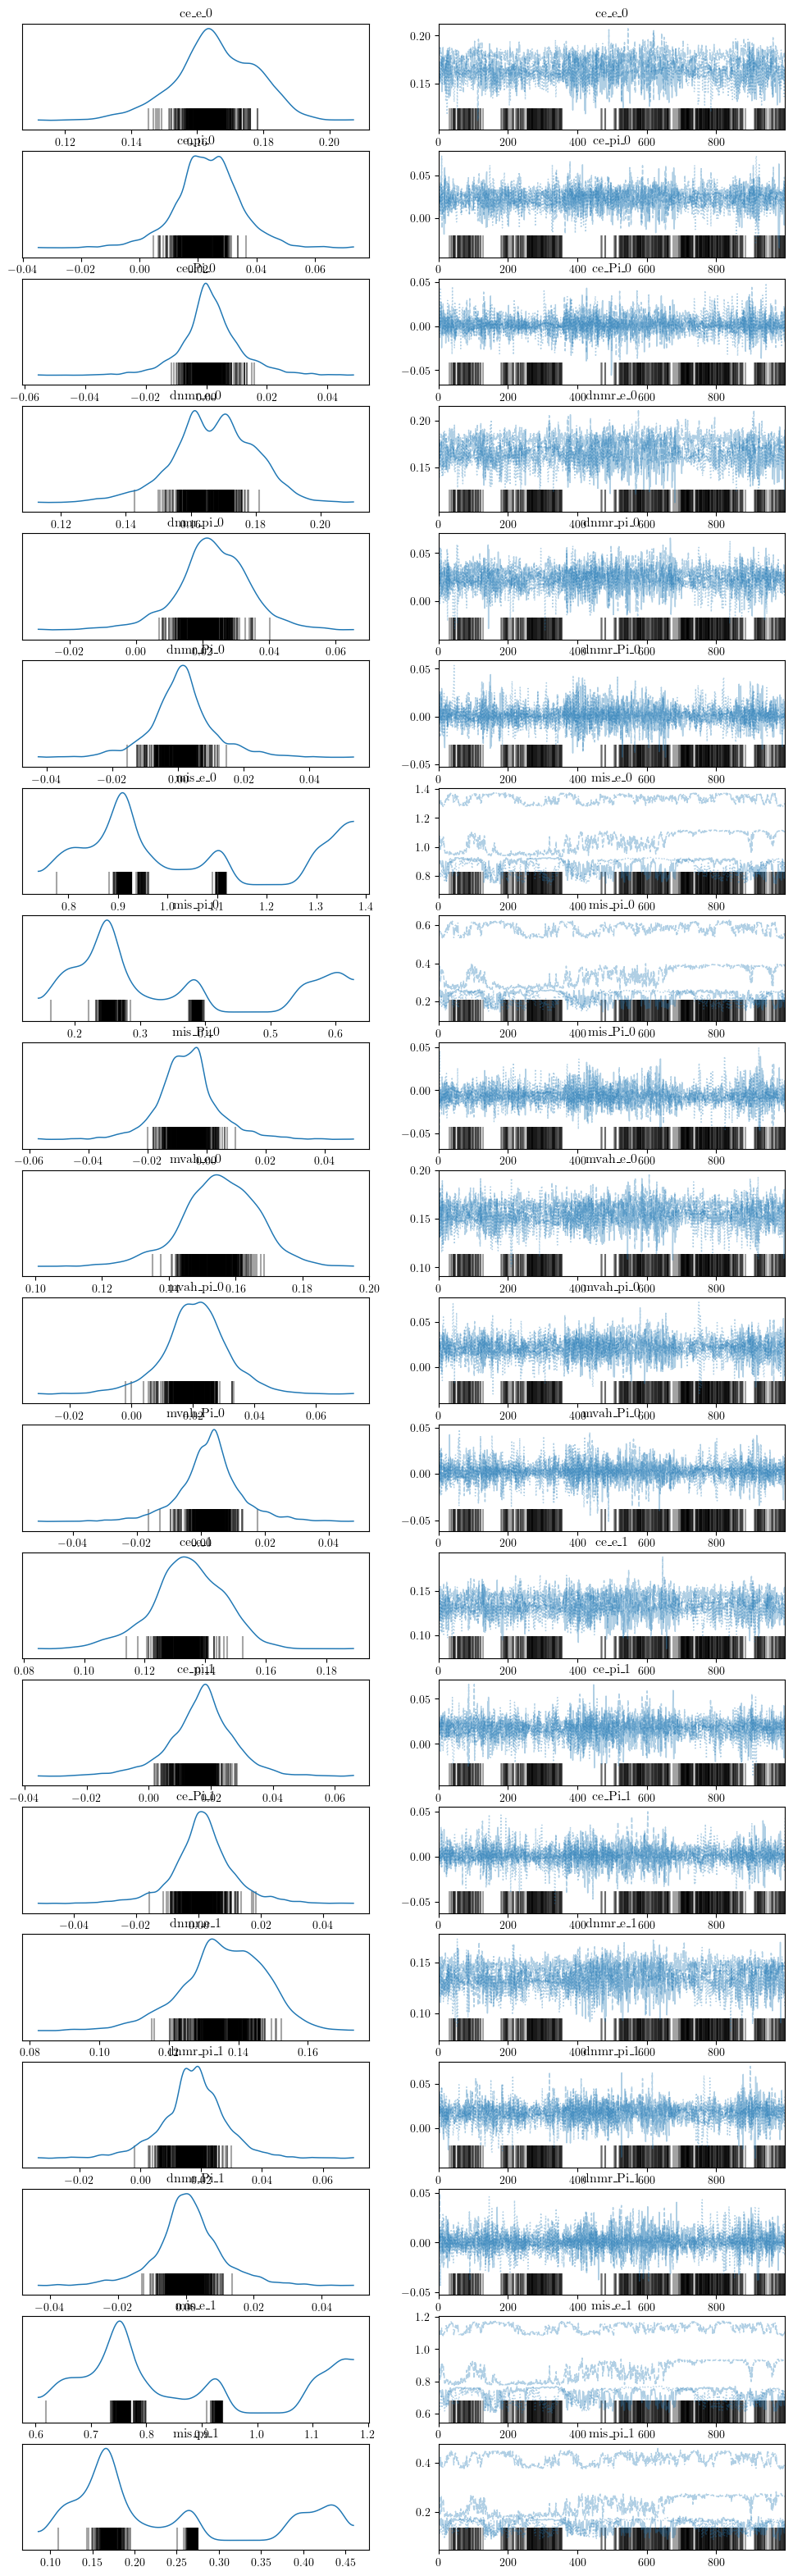

In [7]:
%%time

# simultaneous calibration
inference_data = simultaneous_calibration(
    hydro_names=hydro_names,
    hydro_inference_parameters=hydro_inference_parameters,
    hydro_inference_parameters_ranges=hydro_inference_parameters_ranges,
    observation_times=simulation_taus,
    observation_data=data,
    observation_error=error_bar,
    emulator_training_data=emulator_training_data,
    emulator_design_points=design_points,
)

(4, 1000, 4)


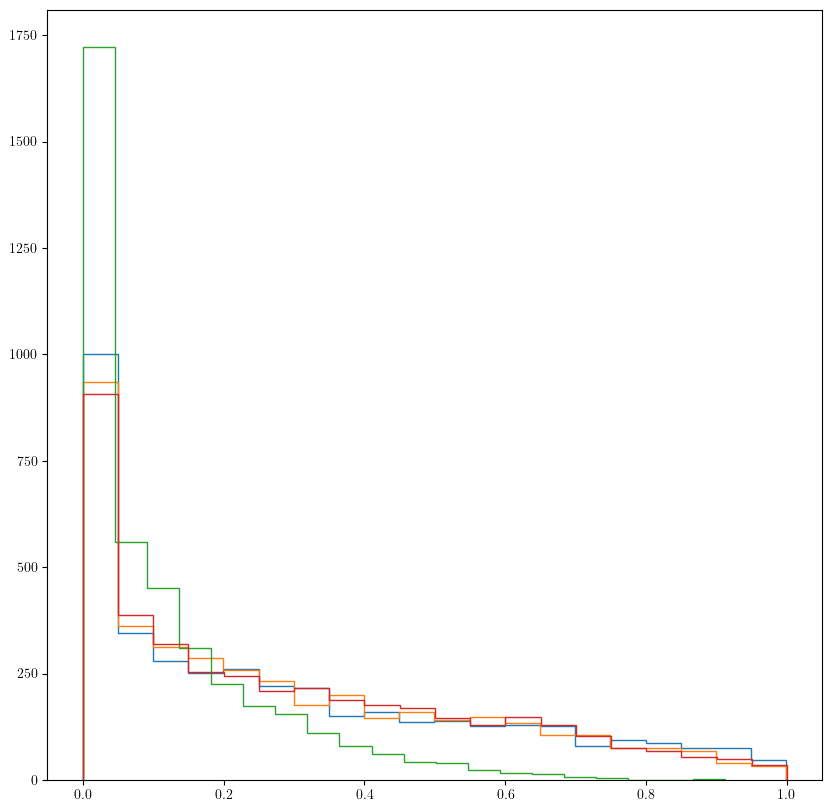

In [8]:
print(inference_data.posterior['Dirichlet_0'].shape)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(inference_data.posterior['Dirichlet_0'].shape[0]):
    ax.hist(np.array(inference_data.posterior['Dirichlet_0'][..., i]).flatten(), histtype='step', bins=20)

(4, 1000, 1, 1)


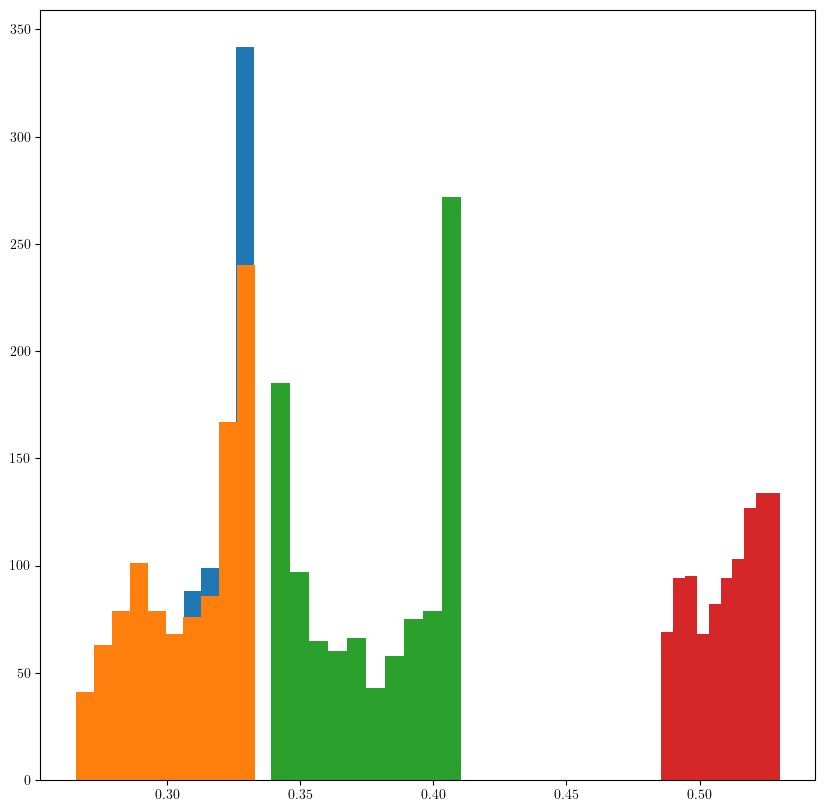

In [13]:
print(inference_data.posterior['hydro_inference_vars'].shape)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(inference_data.posterior['hydro_inference_vars'].shape[0]):
    ax.hist(np.array(inference_data.posterior['hydro_inference_vars'][i]).flatten())

(0.0, 10.0)

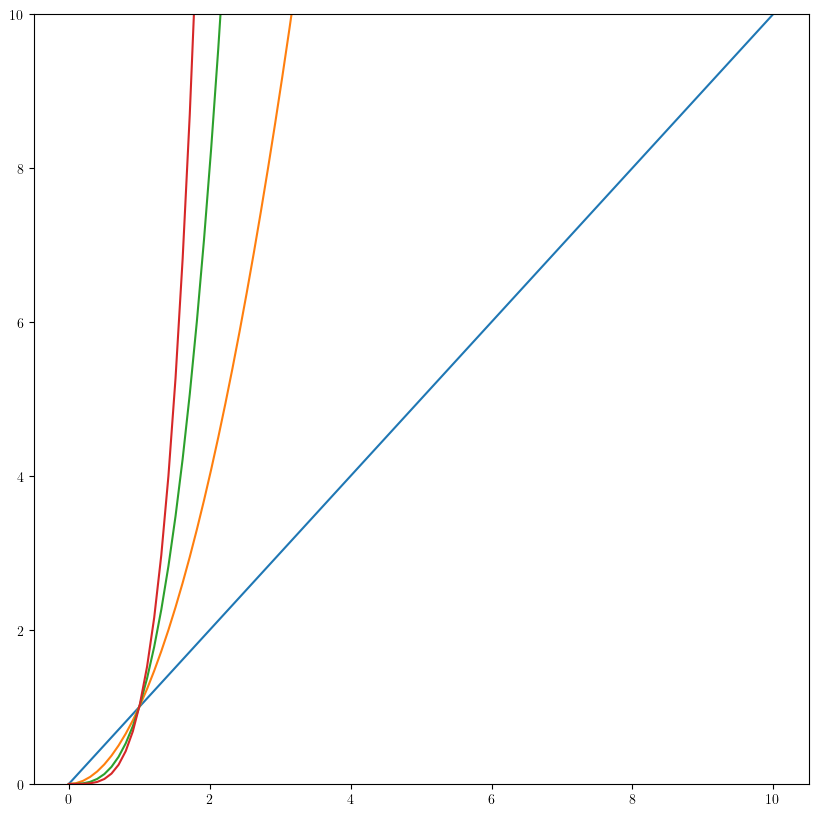

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
x = np.linspace(0, 10, 100)
y = np.array([x, x * x , x ** 3, x ** 4])
for i in range(4):
    ax.plot(x, y[i])
ax.set_ylim(0, 10)

# Full Analysis

## Four Observation Times

In [58]:
%%time 
true_params = local_params

hydro_names = ['ce', 'dnmr', 'mis', 'mvah']
hydro_inference_parameters = ['C']
hydro_inference_parameters_ranges = np.array([[1, 10]]) / (4 * np.pi)
# simulation_taus = np.linspace(5.1, 12.1, 8)
simulation_taus = np.array([1.1, 1.3, 1.5, 1.7])

# Generate psuedo_data
data, error_bar = generate_psuedo_data(
    error_level=0.05,
    parameter_names=hydro_inference_parameters,
    true_params=true_params,
    simulation_taus=simulation_taus,
)

print(data)

# Generate training points to train emulator
design_points, emulator_training_data = generate_emulator_training_points(
    hydro_params_dict=local_params,
    hydro_parameter_names=hydro_inference_parameters,
    hydro_parameter_ranges=hydro_inference_parameters_ranges,
    observation_times=simulation_taus,
)

Initialize temperatures	
Calculating temperature evoluton.	
n = 0, err = 0.7849676469378367	
n = 1, err = 0.06904204591429339	
n = 2, err = 0.05911214773042373	
n = 3, err = 0.044656453786889344	
n = 4, err = 0.031102391898874898	
n = 5, err = 0.02017568697389817	
n = 6, err = 0.012141378812955347	
n = 7, err = 0.006739871199544651	
n = 8, err = 0.0034326798915585532	
n = 9, err = 0.0015914497753295128	
n = 10, err = 0.0006858163667070855	
n = 11, err = 0.0002646386876602925	
n = 12, err = 9.497336963484697e-05	
n = 13, err = 3.391583948231828e-05	
n = 14, err = 6.782937847496284e-06	
n = 15, err = 6.782891839444827e-06	
n = 16, err = 0	
Temperature evolution calculation terminated successfully.	
Calculating moments of distribution function.	
[[1.1        0.85136885 0.35745368 0.06941194]
 [1.3        0.67196175 0.33446106 0.05997336]
 [1.5        0.66627276 0.24827891 0.05371246]
 [1.7        0.50100626 0.23619872 0.05240969]]


dnmr:   0%|                                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

mis:   0%|                                                                                                                                                                              | 0/10 [00:00<?, ?it/s]


ce:  10%|████████████████▋                                                                                                                                                      | 1/10 [00:01<00:10,  1.17s/it]


ce:  20%|█████████████████████████████████▍                                                                                                                                     | 2/10 [00:02<00:09,  1.14s/it]

dnmr:  10%|████████████████▌                                                                                                                                      

CPU times: user 103 ms, sys: 184 ms, total: 287 ms
Wall time: 16min 19s


In [44]:
emulator_training_data['ce'].shape

(1, 10, 4)

In [59]:
%%time

# simultaneous calibration
inference_data = simultaneous_calibration(
    hydro_names=hydro_names,
    hydro_inference_parameters=hydro_inference_parameters,
    hydro_inference_parameters_ranges=hydro_inference_parameters_ranges,
    observation_times=simulation_taus,
    observation_data=data,
    observation_error=error_bar,
    emulator_training_data=emulator_training_data,
    emulator_design_points=design_points,
)

(4, 10, 4)
(4, 4)
Done building PyTensor Graph


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hydro_inference_vars, ce_e_0, ce_e_1, ce_e_2, ce_e_3, ce_pi_0, ce_pi_1, ce_pi_2, ce_pi_3, ce_Pi_0, ce_Pi_1, ce_Pi_2, ce_Pi_3, dnmr_e_0, dnmr_e_1, dnmr_e_2, dnmr_e_3, dnmr_pi_0, dnmr_pi_1, dnmr_pi_2, dnmr_pi_3, dnmr_Pi_0, dnmr_Pi_1, dnmr_Pi_2, dnmr_Pi_3, mis_e_0, mis_e_1, mis_e_2, mis_e_3, mis_pi_0, mis_pi_1, mis_pi_2, mis_pi_3, mis_Pi_0, mis_Pi_1, mis_Pi_2, mis_Pi_3, mvah_e_0, mvah_e_1, mvah_e_2, mvah_e_3, mvah_pi_0, mvah_pi_1, mvah_pi_2, mvah_pi_3, mvah_Pi_0, mvah_Pi_1, mvah_Pi_2, mvah_Pi_3, normal_ce, normal_dnmr, normal_mis, normal_mvah, alpha, Dirichlet]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24576 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 2h 5min 7s, sys: 9.64 s, total: 2h 5min 17s
Wall time: 8h 54min 12s


(4, 1000, 4, 12)


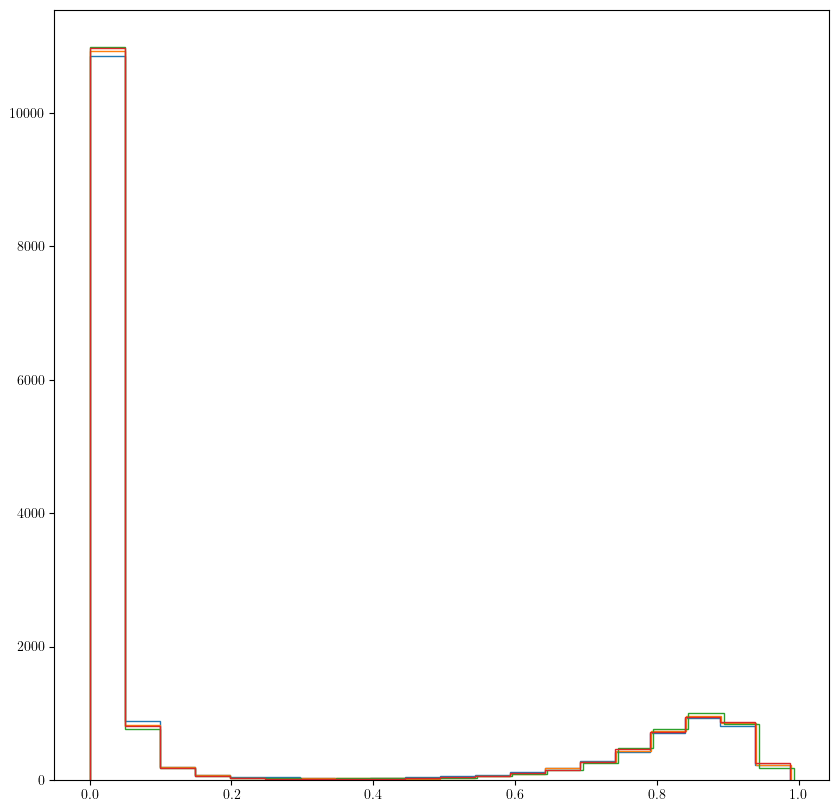

In [62]:
print(inference_data.posterior['Dirichlet'].shape)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(inference_data.posterior['Dirichlet'].shape[0]):
    ax.hist(np.array(inference_data.posterior['Dirichlet'][..., i, ::3]).flatten(), histtype='step', bins=20)

(4, 1000, 1, 1)


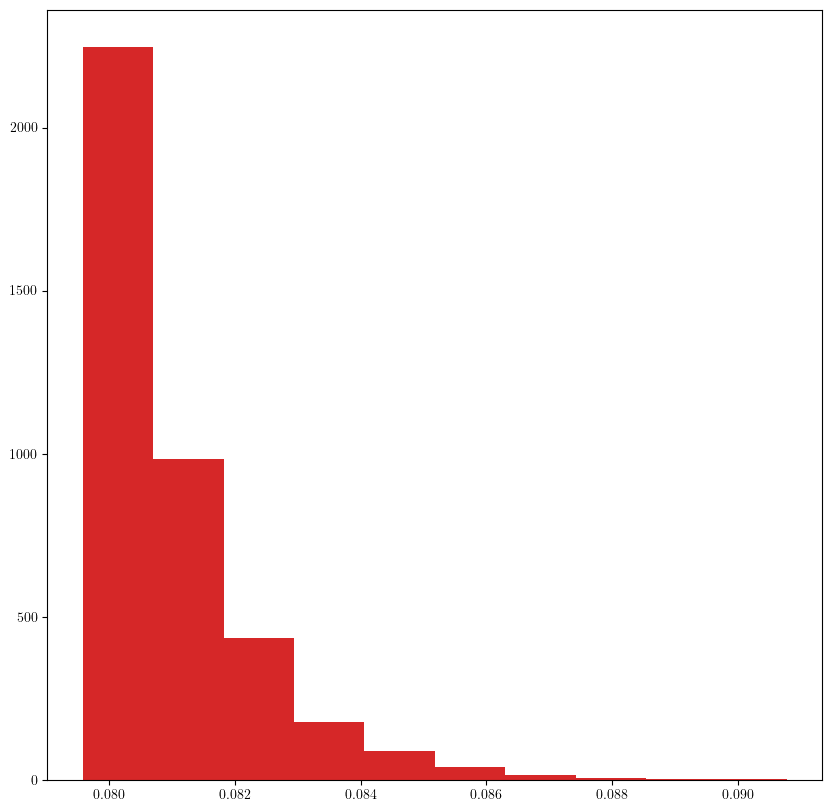

In [71]:
print(inference_data.posterior['hydro_inference_vars'].shape)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(inference_data.posterior['hydro_inference_vars'].shape[0]):
    ax.hist(np.array(inference_data.posterior['hydro_inference_vars']).flatten())

In [70]:
a = np.arange(63).reshape(7, 9)
print(a)
print(a[:, ::3])

[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]
 [27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 41 42 43 44]
 [45 46 47 48 49 50 51 52 53]
 [54 55 56 57 58 59 60 61 62]]
[[ 0  3  6]
 [ 9 12 15]
 [18 21 24]
 [27 30 33]
 [36 39 42]
 [45 48 51]
 [54 57 60]]


https://scholar.google.com/scholar?start=20&hl=de&as_sdt=400005&sciodt=0,14&cites=16151036860810589394&scipsc=

# Do `scikitlearn` emulators work with PyMC

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl

/home/ominusliticus/python_venvs/pymc5_venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


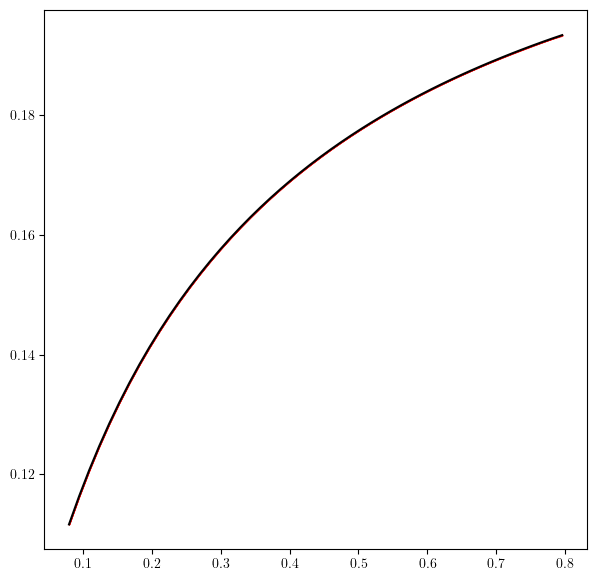

In [26]:
rta_const = np.linspace(1, 10) / (4 * np.pi)

parameter_ranges = np.array([[1, 10]]) / (4 * np.pi)
bounds = np.outer(np.diff(parameter_ranges), (1e-2, 1e2))
kernel = 1 * krnl.RBF(
    length_scale=np.diff(parameter_ranges),
    length_scale_bounds=bounds,
)

gp = gpr(
    kernel=kernel,
    n_restarts_optimizer=40,
    alpha=1e-8,
    normalize_y=True
)

gp.fit(
    design_points.reshape(-1, 1),
    emulator_training_data['ce'][0, :, 1]
)

mean, std = gp.predict(rta_const.reshape(-1, 1), return_std=True)
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(rta_const, mean, color='black')
ax.fill_between(rta_const, mean + std, mean - std, color='red', alpha=0.75);
ax.fill_between(rta_const, mean + 2 * std, mean - 2 * std, color='red', alpha=0.50);
ax.fill_between(rta_const, mean + 3 * std, mean - 3 * std, color='red', alpha=0.25);

In [29]:
with pm.Model() as model:
    c = pm.Uniform('c', parameter_ranges[0, 0], parameter_ranges[0, 1], shape=(1, 1))

    mean, std = gp.predict(c, return_std=True)
    post = pm.Normal('post', mean, std, observed=data[0, 1:])

    idata = pm.sample()

ValueError: Expected 2D array, got scalar array instead:
array=c.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [27]:
data

array([[5.1       , 0.1546577 , 0.05991818, 0.0247807 ]])